# Intro

This project uses the dataset from [The Chars74K dataset](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/)

# Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import os
import cv2
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Preprocessing

In [3]:
# Label class mapping
classMap = list()
# Add 0-9
for i in range(10):
    classMap.append(str(i))
# Add A-Z
for i in range(65, 91):
    classMap.append(chr(i))
# Add a-z
for i in range(97, 123):
    classMap.append(chr(i))

In [4]:
class CharDataSet(Dataset):
    def __init__(self, dataPath, transform=None):
        self.dataPath = dataPath
        # Get all subdirectories in dataPath
        subdirNames = os.listdir(dataPath)
        subdirNames.sort()
        # Get the number of files in each subdirectory
        self.imgs = list()
        self.labels = list()
        for i in range(len(subdirNames)):
            subdirName = subdirNames[i]
            # Get the path of the subdirectory
            subdirPath = os.path.join(dataPath, subdirName)
            # Read all files in the subdirectory
            files = os.listdir(subdirPath)
            # Get file path
            for file in files:
                filePath = os.path.join(subdirPath, file)
                # Read image and label
                img = image.imread(filePath)
                # If image is grayscale, convert to RGB
                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                
                # Transform image
                if transform is not None:
                    img = transform(img)
                # Get label
                label = i
                # Convert to tensor
                label = torch.tensor(label)
                # Add to list
                self.imgs.append(img)
                self.labels.append(label)

    def __getitem__(self, index):
        # Check range
        if index < 0 or index >= len(self):
            raise IndexError("Index out of range")
        
        # Get image and label
        img = self.imgs[index]
        label = self.labels[index]

        return img, label

    def __len__(self):
        # Sum all the files in each subdirectory
        return len(self.imgs)

In [5]:
# Image transform
class ImageTransform():
    def __init__(self, size, normalize=True, toTensor=True):
        self.size = size
        self.normalize = normalize
        self.toTensor = toTensor

    def __call__(self, img: np.ndarray):
        # Resize image
        img = cv2.resize(img, self.size)
        # Normalize image by deviding by max value in image
        if self.normalize:
            img = img / np.amax(img)
        # Convert to tensor
        if self.toTensor:
            img = torch.from_numpy(np.array(img))
        return img

In [6]:
# DATA_SET_PATH = os.path.join(
#     "data","EnglishImg","English","Img","GoodImg","Bmp"
# )
DATA_SET_PATH = os.path.join(
    "data","EnglishFnt","English","Fnt"
)
charDataSet = CharDataSet(dataPath=DATA_SET_PATH, transform=ImageTransform(size=(32, 32)))
dataLoader = DataLoader(charDataSet, batch_size=1, shuffle=True)

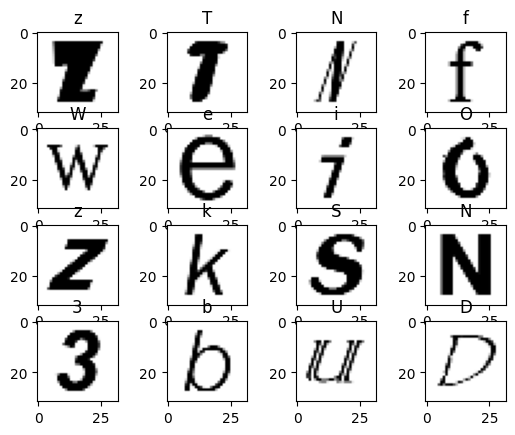

In [7]:
# Display 16 images
charDataIter = iter(dataLoader)
fig, ax = plt.subplots(4, 4)
for i in range(16):
    img, label = next(charDataIter)
    ax[i // 4, i % 4].imshow(img.squeeze().numpy(), cmap="gray")
    ax[i // 4, i % 4].set_title(classMap[label[0]])
plt.show()

# Utils

In [8]:
def GetAccuracy(model, testLoader, testSetSize = -1):
    """
    Get the accuracy of the model on the test set.
    Set the testSetSize to -1 to use the entire test set.
    """
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (imgs, labels) in enumerate(testLoader):
            # Break when reach test set size
            if testSetSize >= 0 and i >= testSetSize:
                break

            # Reshape images to (batch_size, 3, 32, 32)
            imgs = imgs.view(-1, 3, 32, 32)
            imgs = imgs.to(device)
            # Forward pass
            out = model(imgs)
            # Get the index of the max log-probability
            _, predicted = torch.max(out.data, 1)
            # Move predicted to cpu
            predicted = predicted.cpu() 
            # Compute the number of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Compute the accuracy
    accuracy = 100 * correct / total
    return accuracy

# Training

In [9]:
EPOCH = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.01

In [10]:
trainingSetSize = int(len(charDataSet) * 0.8)
trainingDataSet, testingDataSet = torch.utils.data.random_split(
    charDataSet, [trainingSetSize, len(charDataSet) - trainingSetSize], generator=torch.Generator().manual_seed(0)
)

trainLoader = DataLoader(dataset=trainingDataSet, batch_size=BATCH_SIZE, shuffle=True)
testLoader = DataLoader(dataset=testingDataSet, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
# Define the model
class CharClassifier(nn.Module):
    def __init__(self):
        super(CharClassifier, self).__init__()
        # Input size: (3, 32, 32)
        # Convolutional layer 1: (3, 32, 32) -> (16, 30, 30)
        self.conv1 = nn.Conv2d(3, 16, 3)
        # Pooling layer 1: (16, 30, 30) -> (16, 15, 15)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        # Convolutional layer 2: (16, 15, 15) -> (32, 13, 13)
        self.conv2 = nn.Conv2d(16, 32, 3)
        # Pooling layer 2: (32, 13, 13) -> (32, 6, 6)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        # Fully connected layer: (32*6*6) -> (256)
        self.fc1 = nn.Linear(32*6*6, 256)
        # Hidden layer: (256) -> (128)
        self.fc2 = nn.Linear(256, 128)
        # Output layer: (64) -> (size of classMap)
        self.fc3 = nn.Linear(128, len(classMap))

    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = x.view(-1, 32*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Init the model
model = CharClassifier()
# Move the model to GPU if available
model = model.to(device)

# Define the loss function
lossFunc = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [13]:
stepNum = len(trainLoader)
for epoch in range(EPOCH):
    for i, (imgs, labels) in enumerate(trainLoader):
        # Reshape images to (batch_size, 3, 32, 32)
        imgs = imgs.view(-1, 3, 32, 32)
        
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        out = model(imgs)
        
        # Compute loss
        loss = lossFunc(out, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print loss
        if (i + 1) % (stepNum // 4) == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch + 1, EPOCH, i + 1, stepNum, loss.item()))
    # Get accuracy on test set
    accuracy = GetAccuracy(model, testLoader)
    print("Epoch [{}/{}], Test Accuracy: {:.2f}%".format(epoch + 1, EPOCH, accuracy))

Epoch [1/10], Step [787/3150], Loss: 4.1270
Epoch [1/10], Step [1574/3150], Loss: 4.0973
Epoch [1/10], Step [2361/3150], Loss: 4.0336
Epoch [1/10], Step [3148/3150], Loss: 2.0798
Epoch [1/10], Test Accuracy: 35.16%
Epoch [2/10], Step [787/3150], Loss: 1.7777
Epoch [2/10], Step [1574/3150], Loss: 0.9530
Epoch [2/10], Step [2361/3150], Loss: 1.6103
Epoch [2/10], Step [3148/3150], Loss: 1.0776
Epoch [2/10], Test Accuracy: 63.78%
Epoch [3/10], Step [787/3150], Loss: 0.6618
Epoch [3/10], Step [1574/3150], Loss: 0.9120
Epoch [3/10], Step [2361/3150], Loss: 0.3568
Epoch [3/10], Step [3148/3150], Loss: 0.7300
Epoch [3/10], Test Accuracy: 73.05%
Epoch [4/10], Step [787/3150], Loss: 0.4006
Epoch [4/10], Step [1574/3150], Loss: 0.5698
Epoch [4/10], Step [2361/3150], Loss: 0.5655
Epoch [4/10], Step [3148/3150], Loss: 0.7106
Epoch [4/10], Test Accuracy: 75.47%
Epoch [5/10], Step [787/3150], Loss: 0.3607
Epoch [5/10], Step [1574/3150], Loss: 0.6607
Epoch [5/10], Step [2361/3150], Loss: 1.3086
Epoch 

# Accuracy

In [14]:
# Get the accuracy on the test set
accuracy = GetAccuracy(model, testLoader)
print("Test set accuracy: {:.2f}%".format(accuracy))

Test set accuracy: 81.01%
